In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# Toxic Comment Classification

In [2]:
import re
import string

import nltk
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

from utils import data_loader

np.random.seed(0)

<IPython.core.display.Javascript object>

In [3]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yaomingzhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yaomingzhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<IPython.core.display.Javascript object>

In [4]:
TRAIN_FILE = "data/train.csv"
TEST_FILE = "data/test.csv"
TEST_LABEL_FILE = "data/test_labels.csv"

<IPython.core.display.Javascript object>

In [5]:
train_df, valid_df = data_loader.load_train_data(TRAIN_FILE, valid_rate=0.25)
test_df = data_loader.load_test_data(TEST_FILE, TEST_LABEL_FILE)

<IPython.core.display.Javascript object>

## Data Exploration

In [6]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
130060,b7bf5a6846bd456a,"""\n Oppose. WP:MOSTM, the guideline covering t...",0,0,0,0,0,0
132921,c70efd55724be549,=== I AM GLEN AND I LOVE BEING A FAG===,1,0,0,0,0,0
46589,7c7f688f129e511e,"""\n\nIf it happens it may be worth noting but ...",0,0,0,0,0,0
129843,b68d08319e5fcb14,}}\n{{WikiProject Elections and Referendums,0,0,0,0,0,0
2528,06bf9f58011ca46a,"""\n\nI posted a thread about Donny on WP:ANI ...",0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [7]:
valid_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
56041,95bf7672a11f2799,Risk factors\n\nThe role of chlamydia should b...,0,0,0,0,0,0
90055,f0f3d0b835e0caae,Re your reversion of the removal of the websit...,0,0,0,0,0,0
86260,e6b38969b6d30127,But I do hate the_pope and think he I'd a pomp...,1,0,1,0,1,0
30981,524b653cc3469fe8,"""\nI am not interest in a Good Article """"revie...",0,0,0,0,0,0
8241,15e9e6b13c61af45,Hi again! I have added my image with appropria...,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [8]:
test_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [9]:
COMMENT = "comment_text"
LABELS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

<IPython.core.display.Javascript object>

In [10]:
def strip_punctuations(s, replace=" "):
    s = s.translate(str.maketrans("", "", string.punctuation))
    return re.sub(r"\s+", replace, s)

<IPython.core.display.Javascript object>

In [11]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
130060,b7bf5a6846bd456a,"""\n Oppose. WP:MOSTM, the guideline covering t...",0,0,0,0,0,0
132921,c70efd55724be549,=== I AM GLEN AND I LOVE BEING A FAG===,1,0,0,0,0,0
46589,7c7f688f129e511e,"""\n\nIf it happens it may be worth noting but ...",0,0,0,0,0,0
129843,b68d08319e5fcb14,}}\n{{WikiProject Elections and Referendums,0,0,0,0,0,0
2528,06bf9f58011ca46a,"""\n\nI posted a thread about Donny on WP:ANI ...",0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [12]:
comment_lengths = train_df[COMMENT].str.len()
print("min length of comments: ", comment_lengths.min())
print("max length of comments: ", comment_lengths.max())
print("mean length of comments: ", comment_lengths.mean())

min length of comments:  6
max length of comments:  5000
mean length of comments:  393.94203492456427


<IPython.core.display.Javascript object>

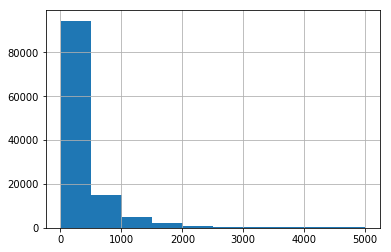

<IPython.core.display.Javascript object>

In [13]:
comment_lengths.hist()

In [14]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

<IPython.core.display.Javascript object>

### Distributions of Different Labels

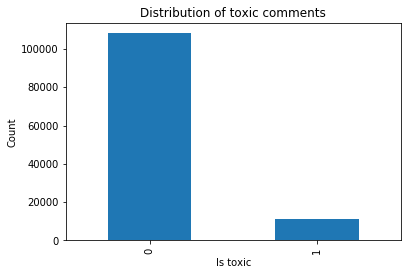

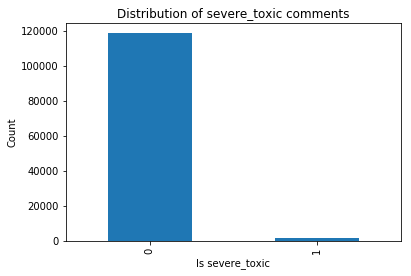

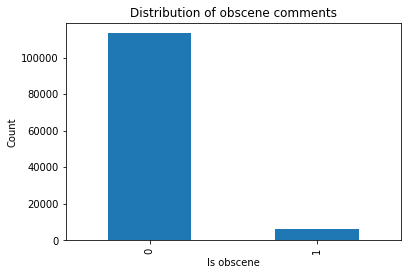

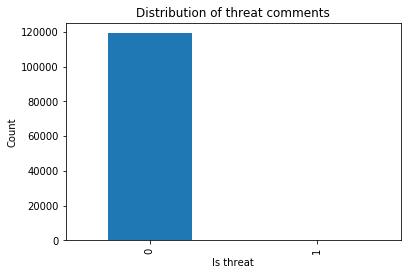

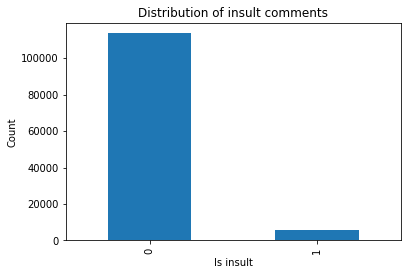

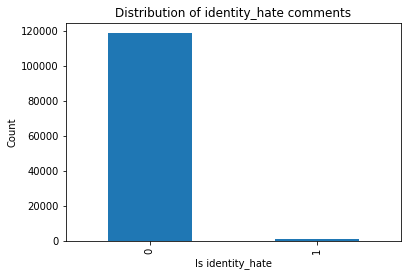

<IPython.core.display.Javascript object>

In [15]:
def show_column_distribution(labels):
    for label in labels:
        train_df[label].value_counts().plot.bar()
        plt.title("Distribution of %s comments" % label)
        plt.xlabel("Is %s" % label)
        plt.ylabel("Count")
        plt.show()


show_column_distribution(LABELS)

### Relationship between "Toxic" and other labels

In [16]:
def find_toxic_percentage(labels):
    for label in labels:
        df = train_df[train_df[label] == 1]
        percentage = (df[df["toxic"] == 1].shape[0] / df.shape[0]) * 100
        print("%.2f %% of %s comments are toxic" % (percentage, label))


find_toxic_percentage(LABELS)

100.00 % of toxic comments are toxic
100.00 % of severe_toxic comments are toxic
93.83 % of obscene comments are toxic
93.35 % of threat comments are toxic
93.59 % of insult comments are toxic
92.50 % of identity_hate comments are toxic


<IPython.core.display.Javascript object>

### Adding in new features and examine their relationships with toxicness

In [17]:
def add_features(df):
    def count_caps_percentage(s):
        s = strip_punctuations(s, replace="")
        cnt = sum(1 for ch in s if ch.isupper())
        return 0 if cnt == 0 else int((cnt / len(s)) * 100)

    df["question_mark_count"] = df[COMMENT].apply(lambda s: s.count("?"))
    df["exclamation_mark_count"] = df[COMMENT].apply(lambda s: s.count("!"))
    df["caps_percentage"] = df[COMMENT].apply(count_caps_percentage)


def strip_punctuations_for_df(df):
    df[COMMENT] = df[COMMENT].apply(strip_punctuations)


add_features(train_df)

<IPython.core.display.Javascript object>

In [18]:
QUESTIONS = "question_mark_count"
EXCLAMATIONS = "exclamation_mark_count"
CAPS_PERCENTAGE = "caps_percentage"

FEATURES = [COMMENT, QUESTIONS, EXCLAMATIONS, CAPS_PERCENTAGE]

<IPython.core.display.Javascript object>

In [19]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,question_mark_count,exclamation_mark_count,caps_percentage
130060,b7bf5a6846bd456a,"""\n Oppose. WP:MOSTM, the guideline covering t...",0,0,0,0,0,0,0,0,8
132921,c70efd55724be549,=== I AM GLEN AND I LOVE BEING A FAG===,1,0,0,0,0,0,0,0,100
46589,7c7f688f129e511e,"""\n\nIf it happens it may be worth noting but ...",0,0,0,0,0,0,0,0,3
129843,b68d08319e5fcb14,}}\n{{WikiProject Elections and Referendums,0,0,0,0,0,0,0,0,11
2528,06bf9f58011ca46a,"""\n\nI posted a thread about Donny on WP:ANI ...",0,0,0,0,0,0,0,0,5


<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


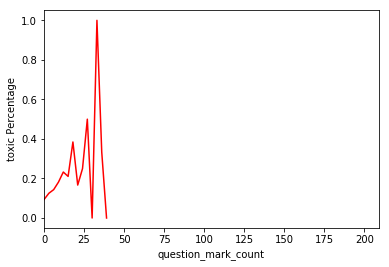

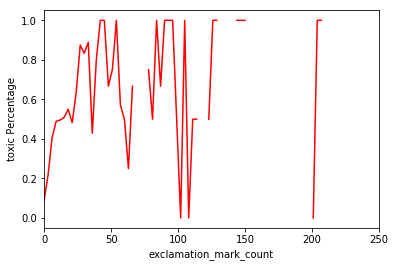

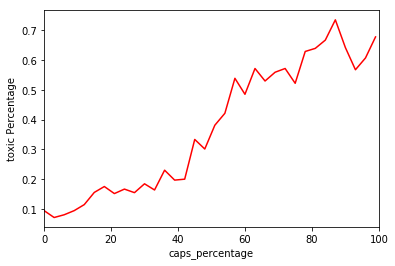

<IPython.core.display.Javascript object>

In [20]:
def plot_relationship(df, features, target):
    step = 3
    for i in range(1, len(features)):
        feature = features[i]
        x, y = [], []
        for n in range(df[feature].min(), df[feature].max() + 1, step):
            x.append(n)
            criteria = (df[feature] >= n) & (df[feature] < n + step)
            cnt = df[criteria].size
            toxic_cnt = df[(criteria) & (df[target] == 1)].size
            y.append(toxic_cnt / cnt)
        plt.plot(x, y, "r-")
        plt.xlabel(feature)
        plt.ylabel("%s Percentage" % target)
        plt.xlim(
            0, min(250, df[feature].max())
        )  # set xlim to 250 so that plot for exclamation_count won't be too large
        plt.show()


plot_relationship(train_df, FEATURES, "toxic")

From the plots we can tell that `question_mark_count` and `caps_percentage` can be used to tell if a comment is toxic or not. No general trend has been found between toxicness and `exclamation_mark_count`.

### Cleaning Data

In [21]:
def transform_text(df):
    """
    Remove punctuations and stopwords from comment, and lemmatize words.
    """

    def clean(s, stop, lemmatizer):
        cleaned = [lemmatizer.lemmatize(w) for w in s.lower().split() if w not in stop]
        return " ".join(cleaned)

    cleaned_df = df.copy()
    strip_punctuations_for_df(cleaned_df)
    stop = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    cleaned_df[COMMENT] = cleaned_df[COMMENT].apply(
        lambda s: clean(s, stop, lemmatizer)
    )
    return cleaned_df


cleaned_df = transform_text(train_df)

<IPython.core.display.Javascript object>

In [22]:
cleaned_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,question_mark_count,exclamation_mark_count,caps_percentage
130060,b7bf5a6846bd456a,oppose wpmostm guideline covering trademark br...,0,0,0,0,0,0,0,0,8
132921,c70efd55724be549,glen love fag,1,0,0,0,0,0,0,0,100
46589,7c7f688f129e511e,happens may worth noting present view like adv...,0,0,0,0,0,0,0,0,3
129843,b68d08319e5fcb14,wikiproject election referendum,0,0,0,0,0,0,0,0,11
2528,06bf9f58011ca46a,posted thread donny wpani saturday 1 accused w...,0,0,0,0,0,0,0,0,5


<IPython.core.display.Javascript object>

### Checking what words have highest frequenct in toxic comments using WordCloud

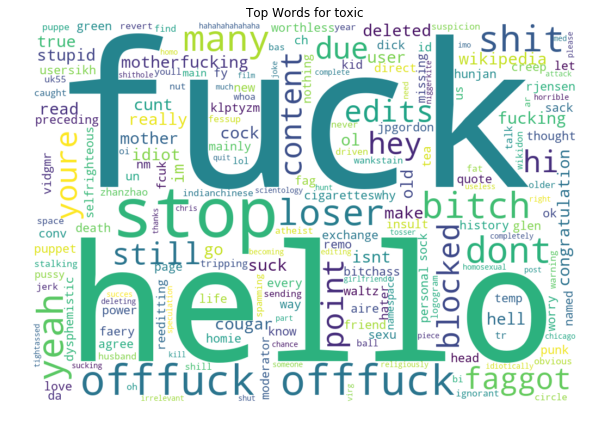

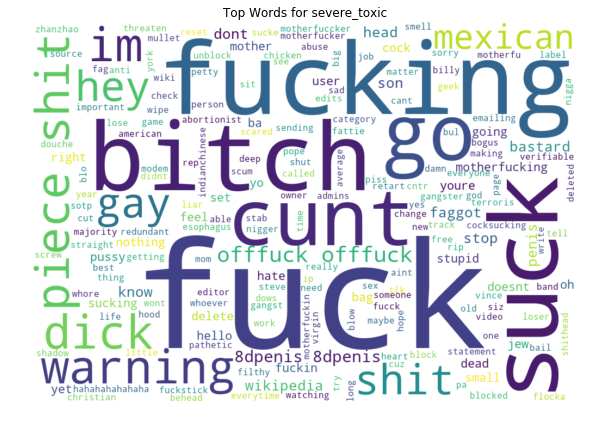

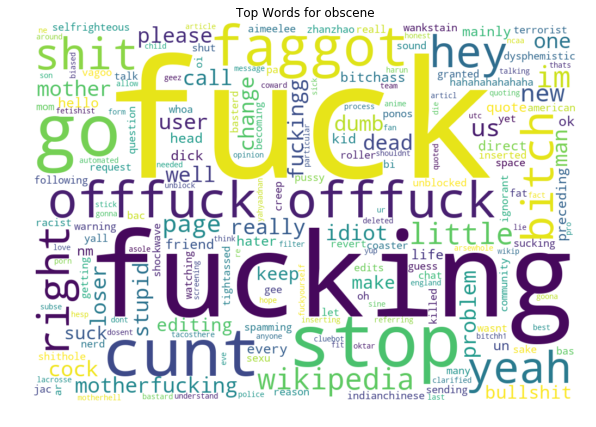

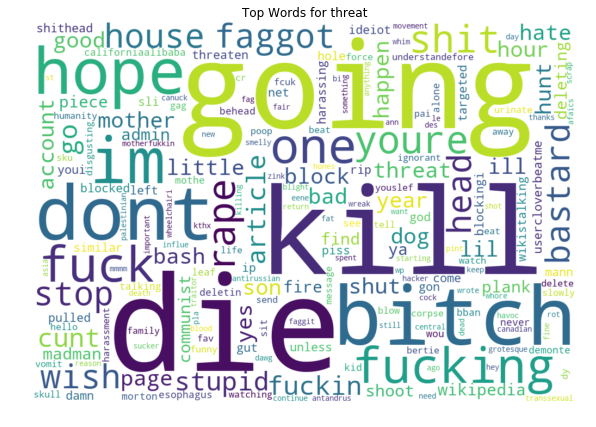

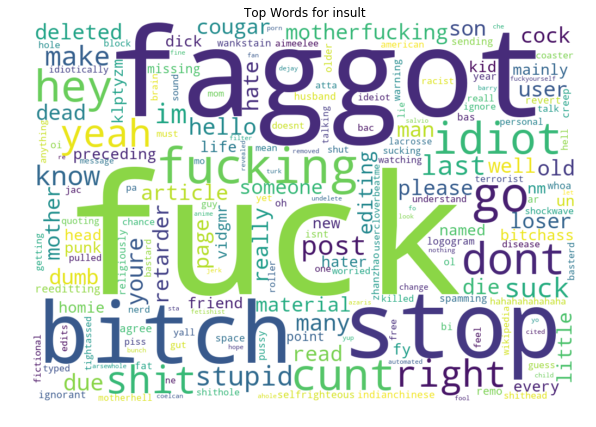

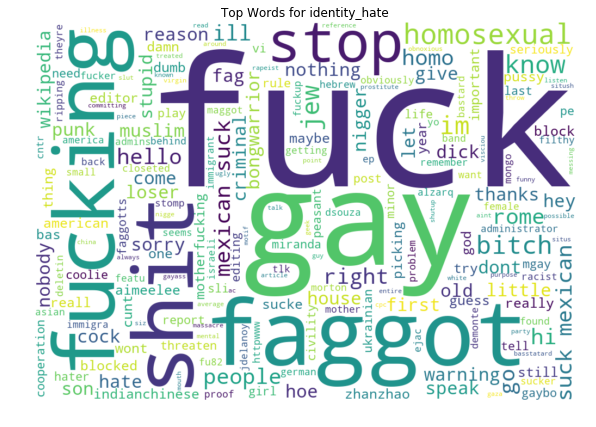

<IPython.core.display.Javascript object>

In [23]:
def generate_wordcloud(df, target):
    text = df[df[target] == 1][COMMENT]
    wordcloud = WordCloud(
        width=1000, height=700, background_color="white", stopwords=STOPWORDS
    ).generate(str(text))
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Top Words for %s" % target)
    plt.show()


for label in LABELS:
    generate_wordcloud(cleaned_df, label)

### Changing the comments into TF-IDF representation

In [ ]:
# TODO